# Results plots

This notebook contains all the results plots using all the data extracted from the `main/pick_best_models.py` script with the `conf/tyra.yaml` configuration file. This plots will use different levels of treatment: `dnbr` and `frp` under different population of vegetation: `conifers` , `shrublands`, and `all` (removing all urban and agricultural areas). The outcomes are the following:
 - **dnbr**: The difference between the pre and post fire NBR values.
 - **frp**: The Fire Radiative Power (FRP) values.
 - **emissions**: The emissions values.

Following the `tyra` configuration, the best results and weights for each combination of treatment and vegetation type are stored in the `best_models/` folder with treatment and vegetation best weights and balancing results according with `loss` and `asmd`, our two metrics of interest during the optimization process in the `main/balancing.py`.  

In [1]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from prescribed.estimate.calculate_estimator import calculate_estimator
from prescribed.plot import (
    annotate_axes,
    plot_loss_check,
    plot_outcomes,
    plot_std_diffs,
    plot_std_diffs_focal_year,
    template_plots,
)
from prescribed.utils import prepare_template

In [2]:
# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Noto Mono"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

In [3]:
# Set numpy seed to get consistent plots and bootstrap stuff
np.random.seed(42)

In [4]:
conifers_loss = {
    "std_diffs_dnbr": pd.read_csv(
        "../best_models/dnbr_treatment/best_model_loss_std_diffs.csv"
    ),
    "std_diffs_frp": pd.read_csv(
        "../best_models/frp_treatment/best_model_loss_std_diffs.csv"
    ),
    "weights_dnbr": pd.read_csv(
        "../best_models/dnbr_treatment/best_model_loss_weights.csv"
    ),
    "weights_frp": pd.read_csv(
        "../best_models/frp_treatment/best_model_loss_weights.csv"
    ),
}

shrubs_loss = {
    "std_diffs_dnbr": pd.read_csv(
        "../best_models/dnbr_treat_shrubs/best_model_loss_std_diffs.csv"
    ),
    "std_diffs_frp": pd.read_csv(
        "../best_models/frp_treat_shrubs/best_model_loss_std_diffs.csv"
    ),
    "weights_dnbr": pd.read_csv(
        "../best_models/dnbr_treat_shrubs/best_model_loss_weights.csv"
    ),
    "weights_frp": pd.read_csv(
        "../best_models/frp_treat_shrubs/best_model_loss_weights.csv"
    ),
}

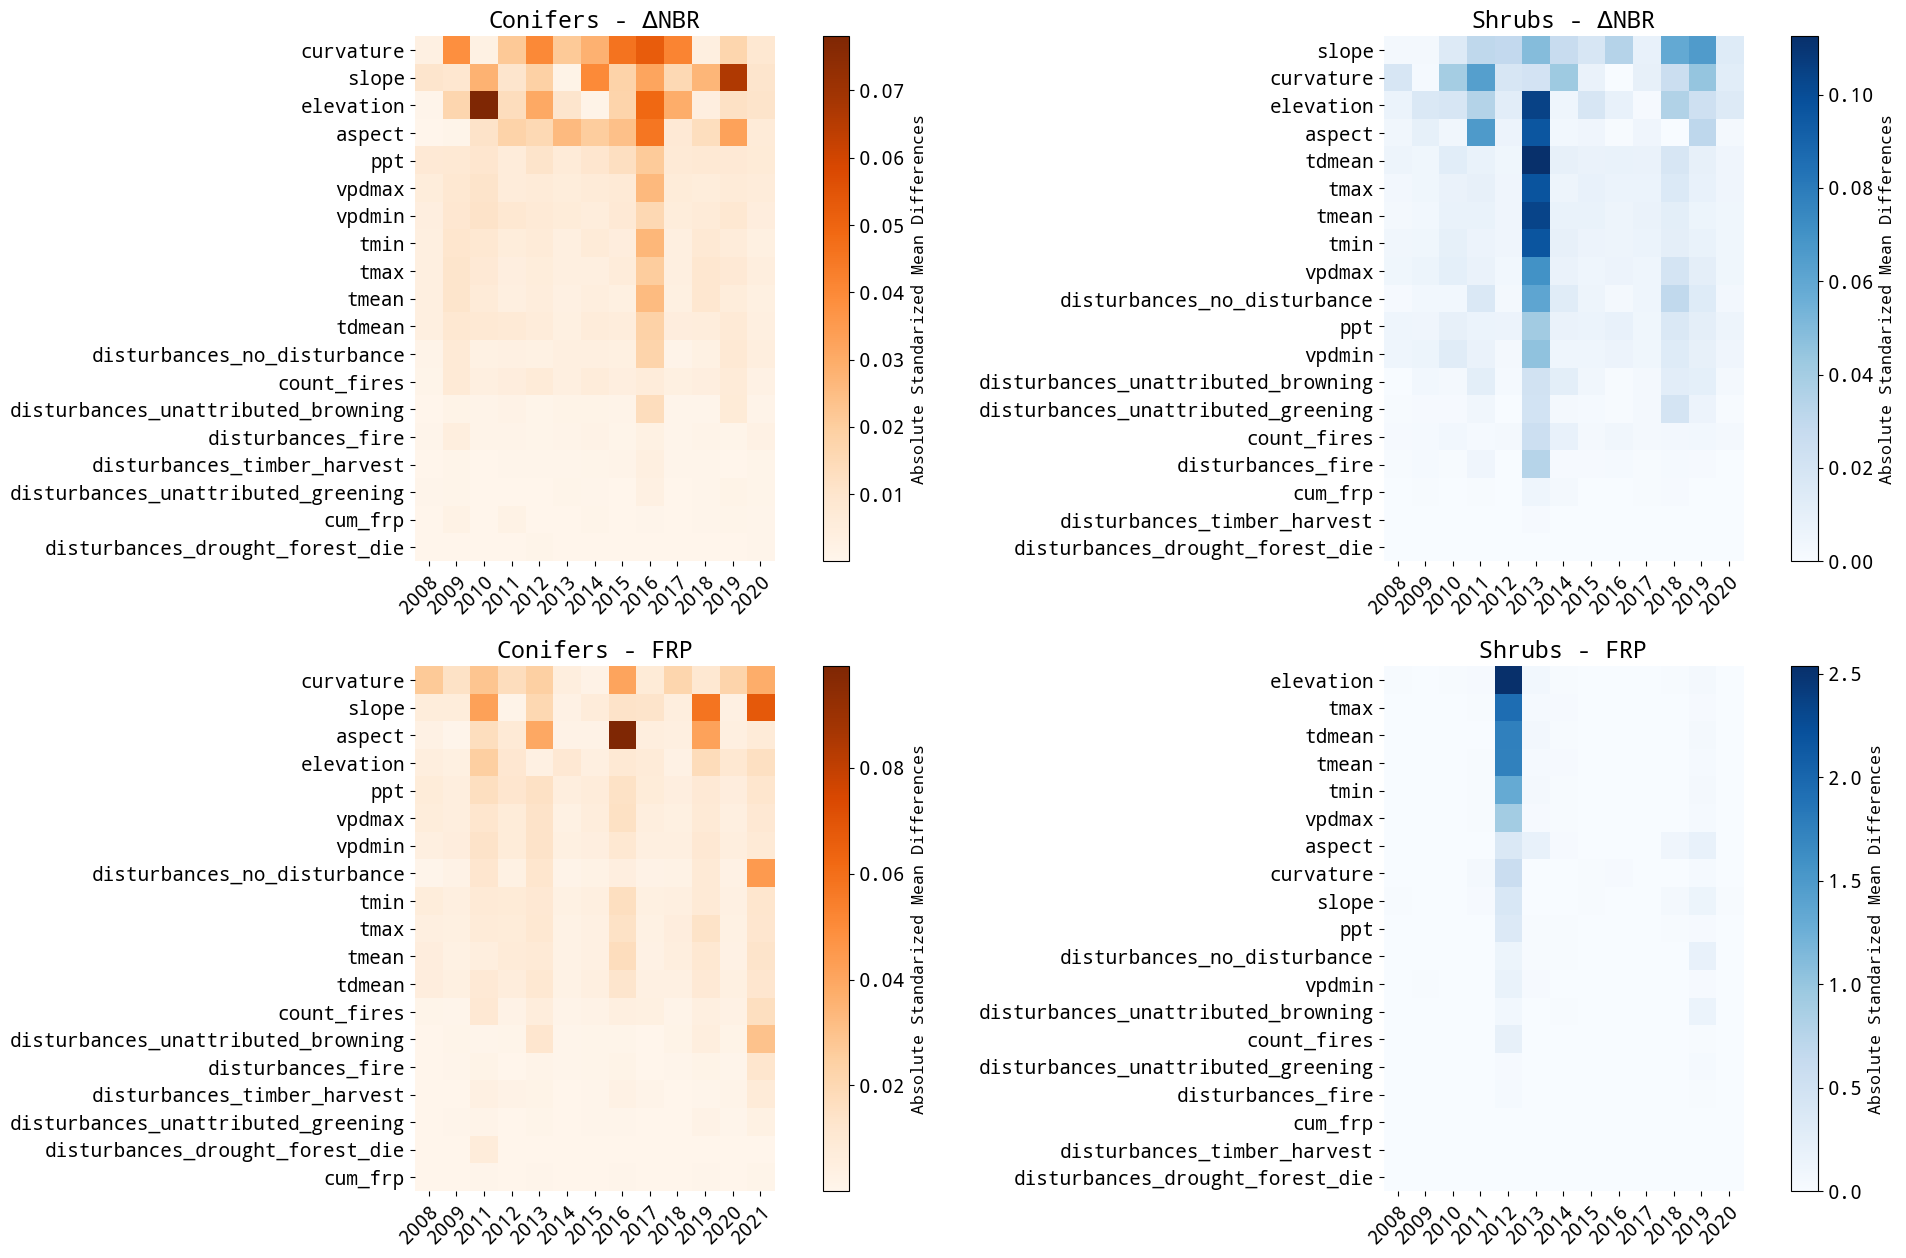

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(25, 15))
plot_std_diffs(
    std_diffs_df=conifers_loss["std_diffs_dnbr"],
    palette="Oranges",
    drop_vars=["Intercept", "land_type"],
    ax=ax[0, 0],
)
plot_std_diffs(
    std_diffs_df=conifers_loss["std_diffs_frp"],
    palette="Oranges",
    drop_vars=["Intercept", "land_type"],
    ax=ax[1, 0],
)

plot_std_diffs(
    std_diffs_df=shrubs_loss["std_diffs_dnbr"],
    palette="Blues",
    ax=ax[0, 1],
    drop_vars=["Intercept", "land_type"],
)
plot_std_diffs(
    std_diffs_df=shrubs_loss["std_diffs_frp"],
    palette="Blues",
    drop_vars=["Intercept", "land_type"],
    ax=ax[1, 1],
)

# At text on the first column
ax[0, 0].set_title(r"Conifers - $\Delta$NBR")
ax[1, 0].set_title("Conifers - FRP")
ax[0, 1].set_title(r"Shrubs - $\Delta$NBR")
ax[1, 1].set_title("Shrubs - FRP")

plt.savefig("../figs/std_diffs_all.png", bbox_inches="tight", dpi=300)

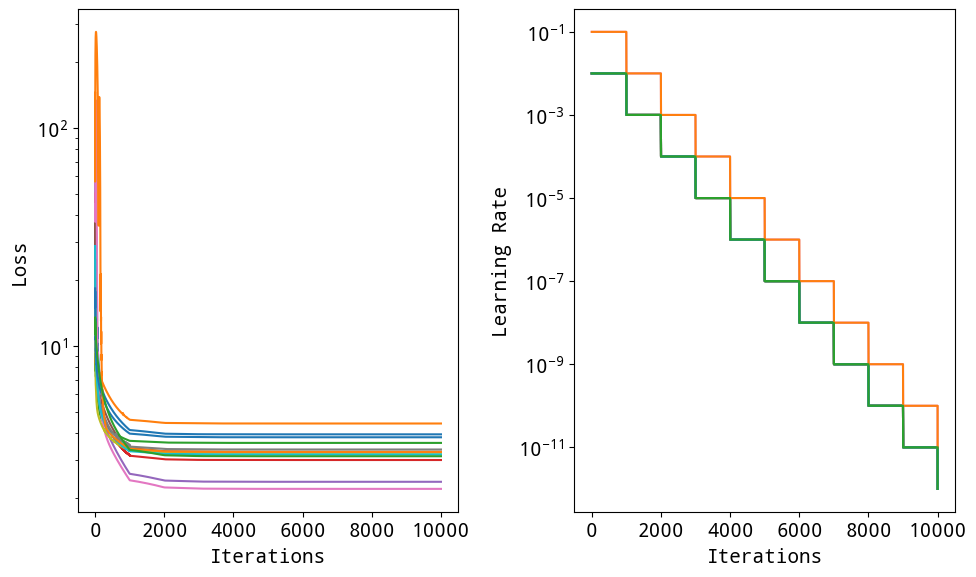

array([<Axes: xlabel='Iterations', ylabel='Loss'>,
       <Axes: xlabel='Iterations', ylabel='Learning Rate'>], dtype=object)

In [7]:
plot_loss_check(
    path_to_losses="/mnt/sherlock/scratch/dnbr_treatment/loss",
    best_model_path="../best_models/dnbr_treatment/best_model_loss.csv",
)

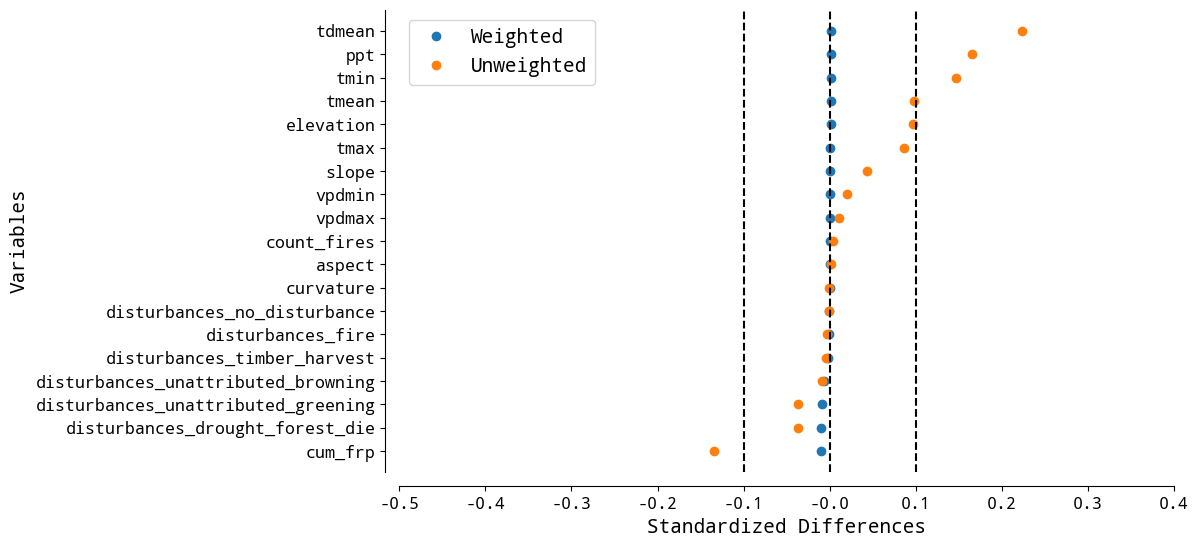

In [58]:
plot_std_diffs_focal_year(
    conifers_loss["std_diffs_dnbr"], 2020, drop_vars=["Intercept", "land_type"]
)

In [15]:
template = (
    prepare_template("/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif")
    .groupby("grid_id")
    .first()
    .reset_index()
    .drop(columns=["year"])
)

# Load California boundaries
ca = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/california_geom/datacalifornia_geom.shp"
).to_crs("3310")

# Load landtypes
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather"
)

# Transform to a GeoDataFrame
land_type = gpd.GeoDataFrame(
    land_type,
    geometry=gpd.points_from_xy(land_type.lon, land_type.lat),
    crs="EPSG:3310",
)

<Axes: >

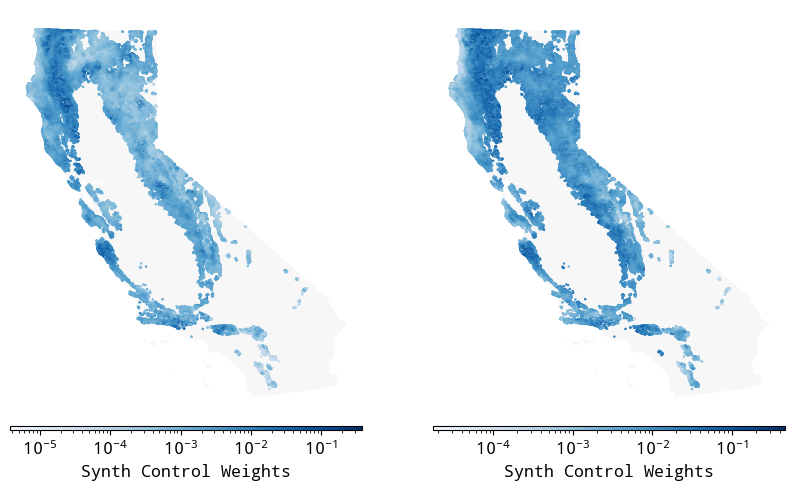

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(10, 15))

# Plot emissions
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="1%", pad=0.1)

# Load conifers weights based on dnbr
weights = conifers_loss["weights_dnbr"].merge(template, on="grid_id")
weights = weights.groupby(["grid_id", "lat", "lon"], as_index=False)["weights"].mean()

weights = gpd.GeoDataFrame(
    weights,
    geometry=gpd.points_from_xy(weights.lon, weights.lat),
    crs="EPSG:3310",
)

norm = norm = LogNorm(vmin=weights["weights"].min(), vmax=weights["weights"].max())

ca.plot(ax=ax[0], color="#d9d9d9", alpha=0.2)

weights.plot(
    ax=ax[0],
    cax=cax,
    column="weights",
    cmap="Blues",
    norm=norm,
    legend=True,
    legend_kwds={"label": "Synth Control Weights", "orientation": "horizontal"},
    markersize=0.6,
)
# Remove the axis labels and lines
template_plots(ax[0], no_axis=True, ylab="", xlab="")


# Plot emissions
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("bottom", size="1%", pad=0.1)

# Load conifers weights based on dnbr
weights = conifers_loss["weights_frp"].merge(template, on="grid_id")
weights = weights.groupby(["grid_id", "lat", "lon"], as_index=False)["weights"].mean()

weights = gpd.GeoDataFrame(
    weights,
    geometry=gpd.points_from_xy(weights.lon, weights.lat),
    crs="EPSG:3310",
)

norm = norm = LogNorm(vmin=weights["weights"].min(), vmax=weights["weights"].max())

ca.plot(ax=ax[1], color="#d9d9d9", alpha=0.2)

weights.plot(
    ax=ax[1],
    cax=cax,
    column="weights",
    cmap="Blues",
    norm=norm,
    legend=True,
    legend_kwds={"label": "Synth Control Weights", "orientation": "horizontal"},
    markersize=0.6,
)
# Remove the axis labels and lines
template_plots(ax[1], no_axis=True, ylab="", xlab="")

# Save plot
# plt.savefig(
#     "../figs/conifers.png",
#     bbox_inches="tight",
#     dpi=300,
#     transparent=True,
# )

## Inference

In [22]:
mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)

mtbs_ca = mtbs[mtbs.Event_ID.str.startswith("CA")].to_crs(3310)
mtbs_ca["Ig_Date"] = pd.to_datetime(mtbs_ca.Ig_Date)
mtbs_ca["year"] = mtbs_ca.Ig_Date.dt.year

In [11]:
# Load data
template = (
    prepare_template("/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif")
    .groupby("grid_id", as_index=False)
    .first()
    .drop(columns=["year"])
)

wide_treatments = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/wide_treatments/wide_treats.feather"
)

frp = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/frp/frp_concat.feather"
)

dnbr = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee/dnbr_long.feather"
)
# dnbr = template.merge(dnbr, on=["lat", "lon"], how="left")
dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year"]], left_on="event_id", right_on="Event_ID", how="left"
)

# scaler = MinMaxScaler(feature_range=(-1, 1))
# dnbr["dnbr"] = scaler.fit_transform(dnbr[["dnbr"]])

# # Re-do dnbr to get years
# dnbr = dnbr.merge(
#     mtbs_ca[["Event_ID", "year"]], left_on="Event_ID", right_on="Event_ID"
# )

# paths_severity = list(
#     Path("/mnt/sherlock/oak/prescribed_data/raw/emissions/emission_CA").rglob("*.grd")
# )

# mtbs_ca_sample = mtbs_ca[
#     mtbs_ca.Event_ID.isin([p.stem.split("_")[0].upper() for p in paths_severity])
# ]

emissions = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/emissions_pm25/emissions_long.feather"
)

# # Merge emissions with mtbs to get year
# emissions = emissions.merge(
#     mtbs_ca[["Event_ID", "year"]], left_on="event_id", right_on="Event_ID", how="left"
# )
# not_matched = emissions[emissions.Event_ID.isna()]
# not_matched["california"] = not_matched.event_id.apply(lambda x: x.split("_")[0][:2])
# not_matched["year"] = not_matched.event_id.apply(lambda x: int(x.split("_")[0][2:6]))

# emissions = pd.concat(
#     [emissions[~emissions.Event_ID.isna()], not_matched[not_matched.california == "CA"]]
# )

# Emissions FINN
emissions_all = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/emissions_finn/finn_GEOSCHEM_mean.feather"
)
emissions_all["year"] = emissions_all["time"].dt.year

In [12]:
import warnings

warnings.filterwarnings("ignore")

# Estimate effects for conifers
df_frp = calculate_estimator(
    treatments=wide_treatments,
    weights=conifers_loss["weights_frp"],
    outcomes=frp,
    focal_year=range(2008, 2021),
    outcome_var="frp",
    low_treatment_class=[2, 1],
    lag_up_to=2021,
)

df_dnbr = calculate_estimator(
    treatments=wide_treatments,
    weights=conifers_loss["weights_dnbr"],
    outcomes=dnbr.dropna(),
    focal_year=range(2008, 2021),
    outcome_var="dnbr",
    low_treatment_class=[2, 1],
    lag_up_to=2021,
)

# Do the same for shrubs
df_frp_shurbs = calculate_estimator(
    treatments=wide_treatments,
    weights=shrubs_loss["weights_frp"],
    outcomes=frp,
    focal_year=range(2008, 2021),
    outcome_var="frp",
    low_treatment_class=[2, 1],
    lag_up_to=2021,
)

df_dnbr_shurbs = calculate_estimator(
    treatments=wide_treatments,
    weights=shrubs_loss["weights_dnbr"],
    outcomes=dnbr.dropna(),
    focal_year=range(2008, 2021),
    outcome_var="dnbr",
    low_treatment_class=[2, 1],
    lag_up_to=2021,
)

df_emissions = calculate_estimator(
    treatments=wide_treatments,
    weights=conifers_loss["weights_dnbr"],
    # outcomes=emissions[emissions.year <= 2020],
    outcomes=emissions_all,
    focal_year=range(2008, 2021),
    # outcome_var="PM2.5",
    outcome_var="PM25",
    low_treatment_class=[2, 1],
    lag_up_to=2021,
    scale=0.001,  # Kg to T
)

df_emissions_shurbs = calculate_estimator(
    treatments=wide_treatments,
    weights=shrubs_loss["weights_dnbr"],
    # outcomes=emissions[emissions.year <= 2020],
    outcomes=emissions_all,
    focal_year=range(2008, 2021),
    # outcome_var="PM2.5",
    outcome_var="PM25",
    low_treatment_class=[2, 1],
    lag_up_to=2021,
    scale=0.001,  # Kg to T
)

Calculating estimator per focal year...:   0%|          | 0/13 [00:00<?, ?it/s]

Calculating estimator per focal year...: 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]


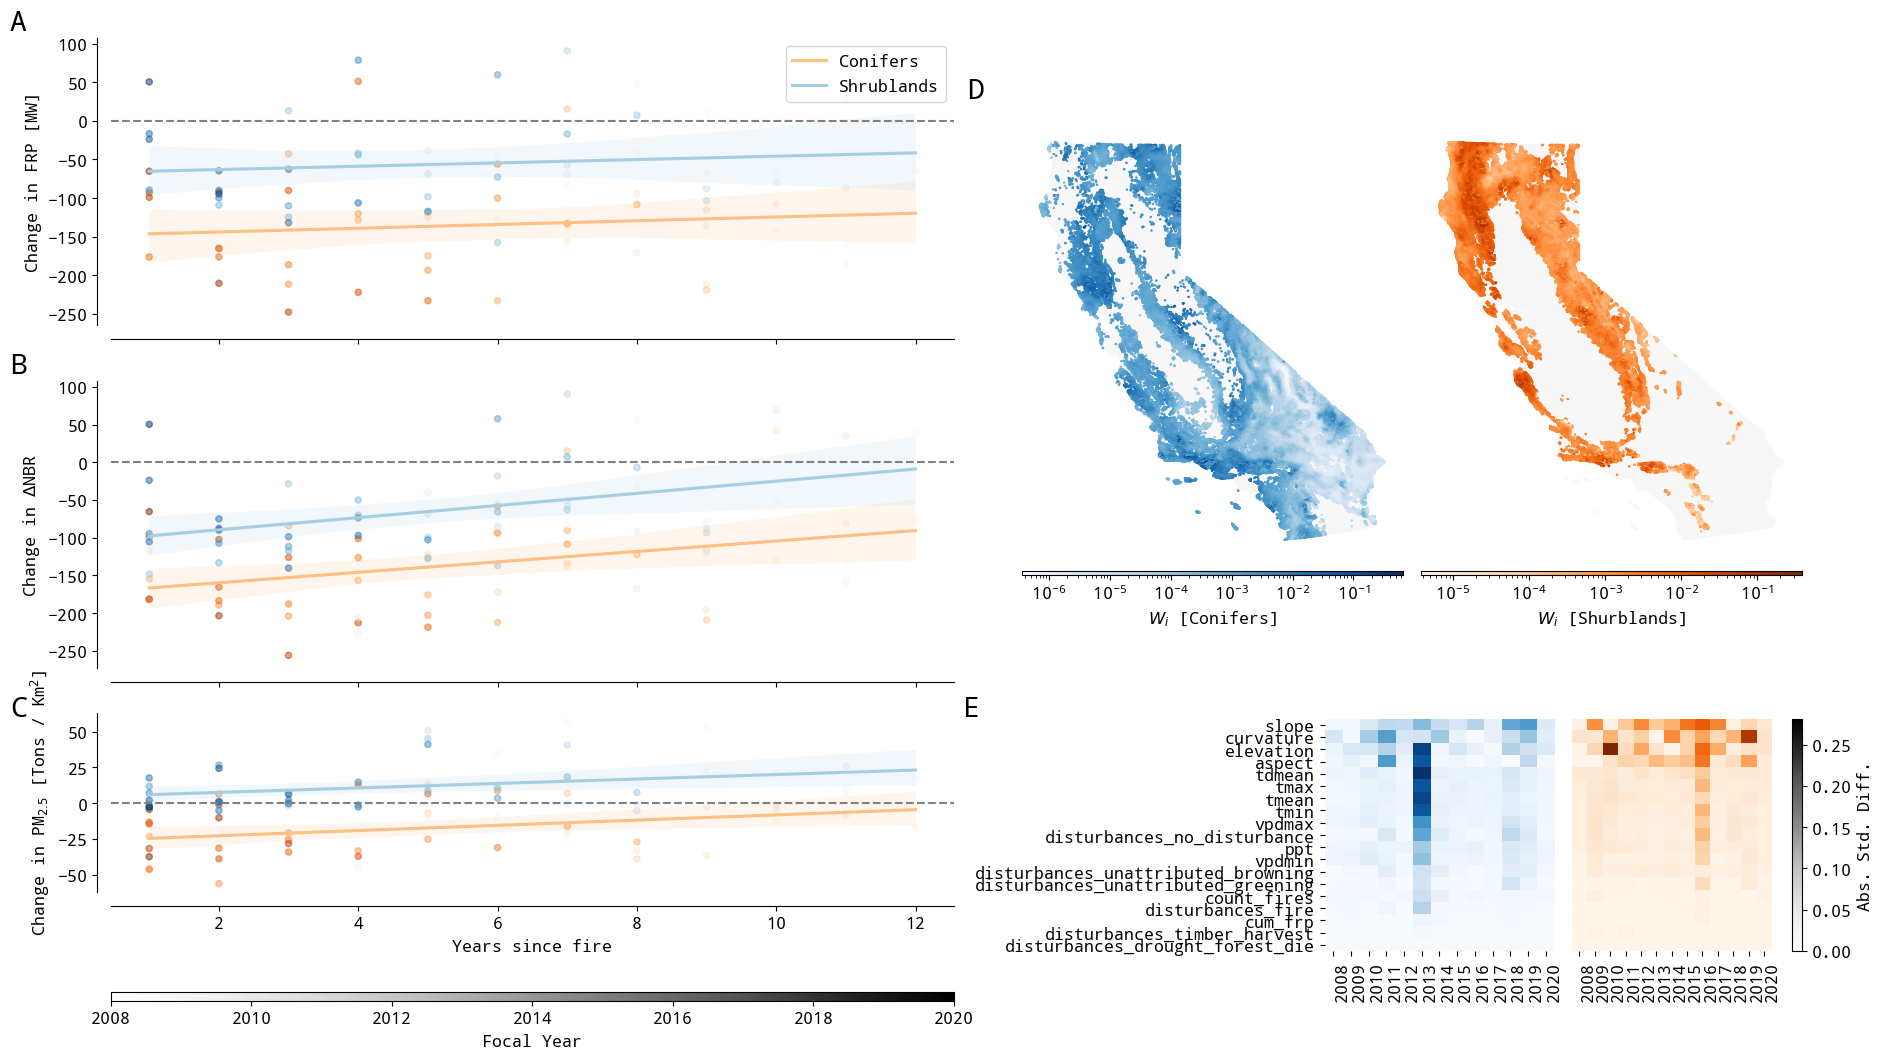

In [62]:
from matplotlib.gridspec import GridSpecFromSubplotSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["font.size"] = 12

fig = plt.figure(figsize=(18, 10), layout="constrained")
spec = fig.add_gridspec(3, 2)

################################################################################
################################# PLOT RESULTS #################################
################################################################################
ax = fig.add_subplot(spec[0, 0])

plot_outcomes(
    df_conifer=df_dnbr,
    df_shrub=df_dnbr_shurbs,
    var_interest="delta_frp",
    axes_names=(
        "Change in FRP [MW]",
        "Years since fire",
    ),
    ax=ax,
    legend=True,
    order=1,
    lowess=False,
    label="A",
)

ax = fig.add_subplot(spec[1, 0], sharex=ax)

plot_outcomes(
    df_conifer=df_dnbr,
    df_shrub=df_dnbr_shurbs,
    var_interest="delta_dnbr",
    axes_names=(
        r"Change in $\Delta$NBR",
        "Years since fire",
    ),
    ax=ax,
    order=1,
    lowess=False,
    label="B",
)

ax = fig.add_subplot(spec[2, 0], sharex=ax)

plot_outcomes(
    df_conifer=df_emissions,
    df_shrub=df_emissions_shurbs,
    var_interest="delta_frp",
    axes_names=(
        r"Change in PM$_{2.5}$ [Tons / Km$^{2}$]",
        "Years since fire",
    ),
    ax=ax,
    order=1,
    lowess=False,
    colorbar=False,
    label="C",
)

# Create a custom colorbar with a different colormap
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=1.0)

fig.colorbar(
    ScalarMappable(norm=Normalize(2008, 2020), cmap="Greys"),
    cax=cax,
    orientation="horizontal",
    label="Focal Year",
)

################################################################################
############################### PLOT WEIGHTS SYNTH #############################
################################################################################

# Create a new grid specification for the subplots
plt.rcParams.update({"font.size": 12})
subspec = GridSpecFromSubplotSpec(1, 2, subplot_spec=spec[0:-1, 1])

ax = fig.add_subplot(subspec[0, 0])
# annotate_axes(ax, "Weights here")

# Plot conifer weights
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="1%", pad=0.1)

# Load conifers weights based on dnbr
weights = shrubs_loss["weights_dnbr"].merge(template, on="grid_id")
weights = weights.groupby(["grid_id", "lat", "lon"], as_index=False)["weights"].mean()

weights = gpd.GeoDataFrame(
    weights,
    geometry=gpd.points_from_xy(weights.lon, weights.lat),
    crs="EPSG:3310",
)

norm = norm = LogNorm(vmin=weights["weights"].min(), vmax=weights["weights"].max())

ca.plot(ax=ax, color="#d9d9d9", alpha=0.2)

weights.plot(
    ax=ax,
    cax=cax,
    column="weights",
    cmap="Blues",
    norm=norm,
    legend=True,
    legend_kwds={"label": r"$W_{i}$ [Conifers]", "orientation": "horizontal"},
    markersize=0.6,
)
# Remove the axis labels and lines
template_plots(ax, no_axis=True, ylab="", xlab="", label="D")


ax = fig.add_subplot(subspec[0, 1])
# annotate_axes(ax, "Weights here")

# Plot shurbs weights
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="1%", pad=0.1)

# Load conifers weights based on dnbr
weights = conifers_loss["weights_dnbr"].merge(template, on="grid_id")
weights = weights.groupby(["grid_id", "lat", "lon"], as_index=False)["weights"].mean()

weights = gpd.GeoDataFrame(
    weights,
    geometry=gpd.points_from_xy(weights.lon, weights.lat),
    crs="EPSG:3310",
)

norm = norm = LogNorm(vmin=weights["weights"].min(), vmax=weights["weights"].max())

ca.plot(ax=ax, color="#d9d9d9", alpha=0.2)

weights.plot(
    ax=ax,
    cax=cax,
    column="weights",
    cmap="Oranges",
    norm=norm,
    legend=True,
    legend_kwds={"label": r"$W_{i}$ [Shurblands]", "orientation": "horizontal"},
    markersize=0.6,
)
# Remove the axis labels and lines
template_plots(ax, no_axis=True, ylab="", xlab="")

################################################################################
######################### PLOT STANDARIZED DIFFERENCES #########################
################################################################################

subspec = GridSpecFromSubplotSpec(1, 2, subplot_spec=spec[2, 1], wspace=0.01)


# Define mins and max for the two plots
v_max = np.max(
    [
        shrubs_loss["std_diffs_dnbr"]["std_weighted_asmd"].max(),
        conifers_loss["std_diffs_dnbr"]["std_weighted_asmd"].max(),
    ]
)

v_min = np.min(
    [
        shrubs_loss["std_diffs_dnbr"]["std_weighted_asmd"].min(),
        conifers_loss["std_diffs_dnbr"]["std_weighted_asmd"].min(),
    ]
)


ax = fig.add_subplot(subspec[0, 0])
im1 = plot_std_diffs(
    std_diffs_df=shrubs_loss["std_diffs_dnbr"],
    palette="Blues",
    ax=ax,
    labels_y=True,
    draw_cbar=False,
    label="E",
    rotation_x=90,
    drop_vars=["Intercept", "land_type"],
)

ax = fig.add_subplot(subspec[0, 1])
im2 = plot_std_diffs(
    std_diffs_df=conifers_loss["std_diffs_dnbr"],
    palette="Oranges",
    labels_y=False,
    draw_cbar=False,
    rotation_x=90,
    drop_vars=["Intercept", "land_type"],
    ax=ax,
)

# Add a shared colorbar between the two plots im1 and im2
# Create a custom colorbar with a different colormap
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

fig.colorbar(
    ScalarMappable(norm=Normalize(vmin=v_min, vmax=v_max), cmap="Greys"),
    cax=cax,
    orientation="vertical",
    label="Abs. Std. Diff.",
)

plt.subplots_adjust(wspace=0.01)

plt.savefig("../figs/fig_results.png", bbox_inches="tight", dpi=300)